#### In this file we are studying the training of the algorithm with a different preprocessing transformation with respect to the `original.ipynb` file. In particular, first we will not use `QuantileTransformer` and then apply it to all features. <pb>
#### To see the differences from the previously trained model we define another flow, without loading the saved model.

In [1]:
!mkdir utils
!mkdir data
!wget --output-document=./utils/model.py https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f&dl=0
!wget --output-document=./utils/our_classes.py https://www.dropbox.com/scl/fi/w8sth2i67t26agcvk8nxt/our_classes.py?rlkey=zdl86xxnogw50didjh7b3isix&dl=0
!wget --output-document=./data/dataset_piccolo.txt https://www.dropbox.com/scl/fi/1m1o6kdbeyd6sid8yuw8q/dataset_piccolo.txt?rlkey=hl8xvtrqj3mch3kjzjegw3wns&dl=0
!wget --output-document=./data/dataset.txt https://www.dropbox.com/scl/fi/wsw8e5uitd50tbjactzl3/dataset.txt?rlkey=arv1nh6dpwg1ipmehf5cvx9y5&dl=0
!wget --output-document=./data/test_dataset.txt https://www.dropbox.com/scl/fi/jhkucfrge74eu65bf5iqy/test_dataset.txt?rlkey=wjgg3rd72t3u47rr0ex8tbwj6&dl=0

!pip install nflows

import torch

from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import stat
import time

Retrieving folder contents
Processing file 17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT dataset_piccolo.txt
Processing file 1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg dataset.txt
Processing file 1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL test_dataset.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT
To: /content/data/dataset_piccolo.txt
100% 78.9M/78.9M [00:00<00:00, 224MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg
From (redirected): https://drive.google.com/uc?id=1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg&confirm=t&uuid=816f0ee9-f4a4-46b5-99f1-0d3fe5d293c2
To: /content/data/dataset.txt
100% 153M/153M [00:00<00:00, 164MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL
From (redirected): https://drive.google.com/uc?id=1XjcRDOZVJV-I6gadgYwebf1Woi08eIEL&confirm=t&uuid=1e8f1a9b

In [2]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

In [3]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}'.format(L))

x = x[:int(L/5),:]
xval = xval[:len(x),:]
xtest = xtest[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest = xtest[:,0:num_features]

Number of events in all the training dataset = 472827



scriviamo ora che non stiamo usando il quantiletransformer

In [4]:
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

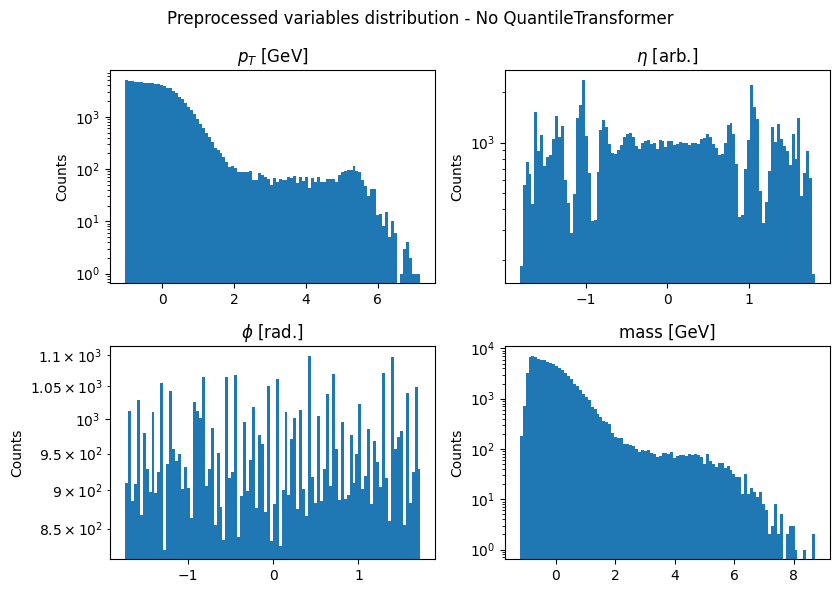

mkdir: cannot create directory ‘figures’: File exists


In [5]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution - No QuantileTransformer")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()
!mkdir figures
fig.savefig('figures/Variables_distribution_transformed_for_no_features.pdf',dpi=190)

In [6]:
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=4, hidden_features=32, patience = 3, factor = 0.25, min_lr = 1e-5, initial_lr = 1e-2)

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


100 tensor(2.9578, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(2.7019, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(2.6020, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(2.5630, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(2.5657, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(2.5101, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(2.5122, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(2.5385, device='cuda:0', grad_fn=<NegBackward0>)
900 tensor(2.5395, device='cuda:0', grad_fn=<NegBackward0>)
1000 tensor(2.5440, device='cuda:0', grad_fn=<NegBackward0>)
Time = 171.77 s


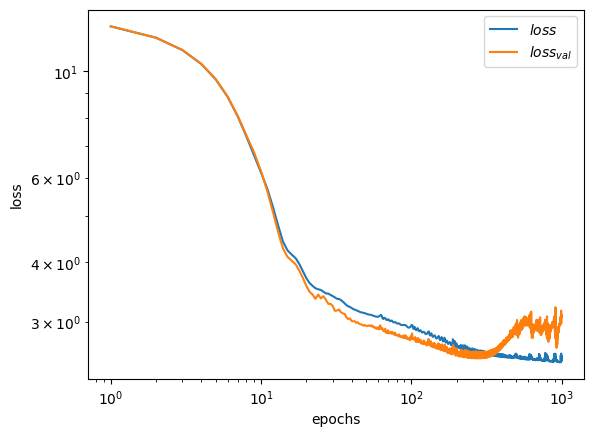

In [7]:
epochs = 1000

figloss=plt.figure()
loss_values = []
loss_validation = []
start = time.time()
for i in range(epochs):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 100 == 0:
    print(i+1,loss)
end = time.time()
print('Time = {:0.05} s'.format(end-start))
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

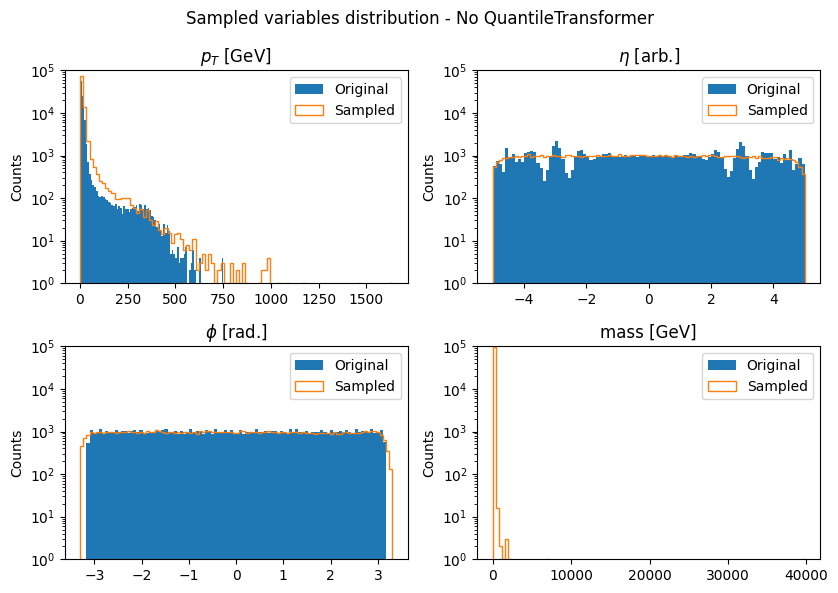

In [8]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution - No QuantileTransformer")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample_noquantile.pdf',dpi=190)

In [9]:
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed, gaus, unif = x_compressor.compress(xt)
x_decompressed, gaus_post = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio with no QuantileTransformer =',size_input/size_compressed)

Size of input file = 5.159041404724121 MB
Size of output file = 3.63362979888916 MB
Size of compressed file = 1.7537651062011719 MB
Compression ratio with no QuantileTransformer = 2.941694635434453


Qui ora facciamo quantile transformer per tutte e quattro

In [10]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}'.format(L))

x = x[:int(L/5),:]
xval = xval[:len(x),:]
xtest = xtest[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest = xtest[:,0:num_features]

preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([0,3]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Number of events in all the training dataset = 472827



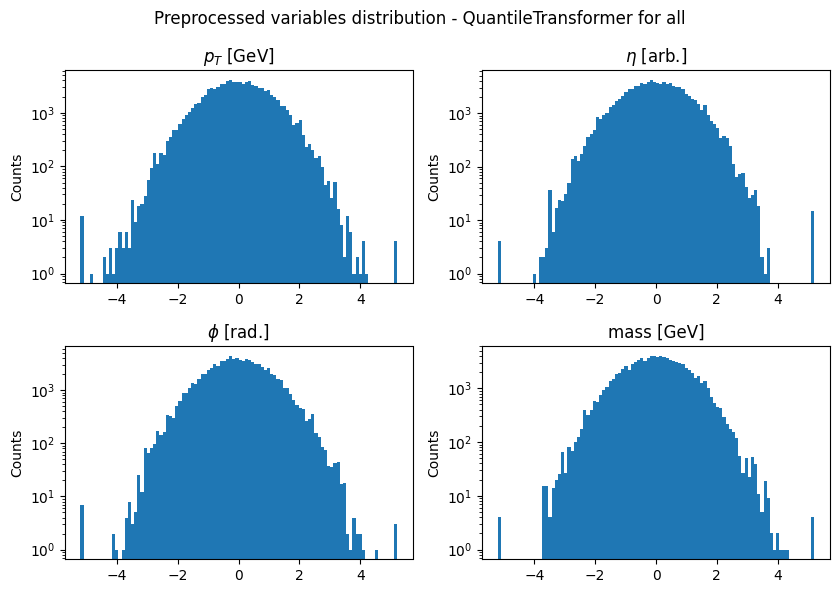

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution - QuantileTransformer for all")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed_for_all_features.pdf',dpi=190)

In [12]:
flow, optimizer = model_definer(num_features=num_features, num_iterations=6, hidden_features=128)

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


100 tensor(3.9962, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(3.8800, device='cuda:0', grad_fn=<NegBackward0>)
300 tensor(3.8028, device='cuda:0', grad_fn=<NegBackward0>)
400 tensor(3.7654, device='cuda:0', grad_fn=<NegBackward0>)
500 tensor(3.7365, device='cuda:0', grad_fn=<NegBackward0>)
600 tensor(3.7131, device='cuda:0', grad_fn=<NegBackward0>)
700 tensor(3.7098, device='cuda:0', grad_fn=<NegBackward0>)
800 tensor(3.7016, device='cuda:0', grad_fn=<NegBackward0>)
900 tensor(3.7047, device='cuda:0', grad_fn=<NegBackward0>)
1000 tensor(3.6931, device='cuda:0', grad_fn=<NegBackward0>)
Time = 169.46 s


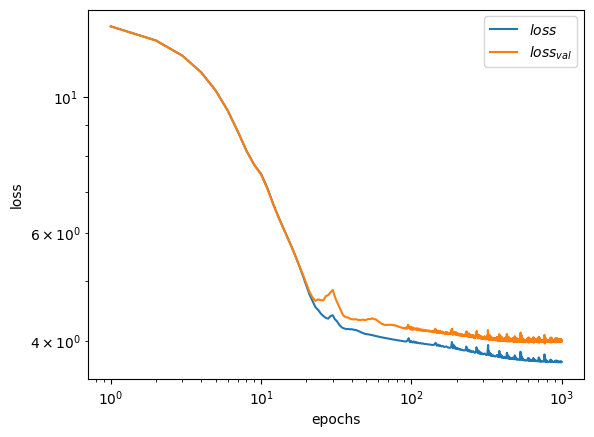

In [13]:
epochs = 1000

figloss=plt.figure()
loss_values = []
loss_validation = []
start = time.time()
for i in range(epochs):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 100 == 0:
    print(i+1,loss)
end = time.time()
print('Time = {:0.05} s'.format(end-start))
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

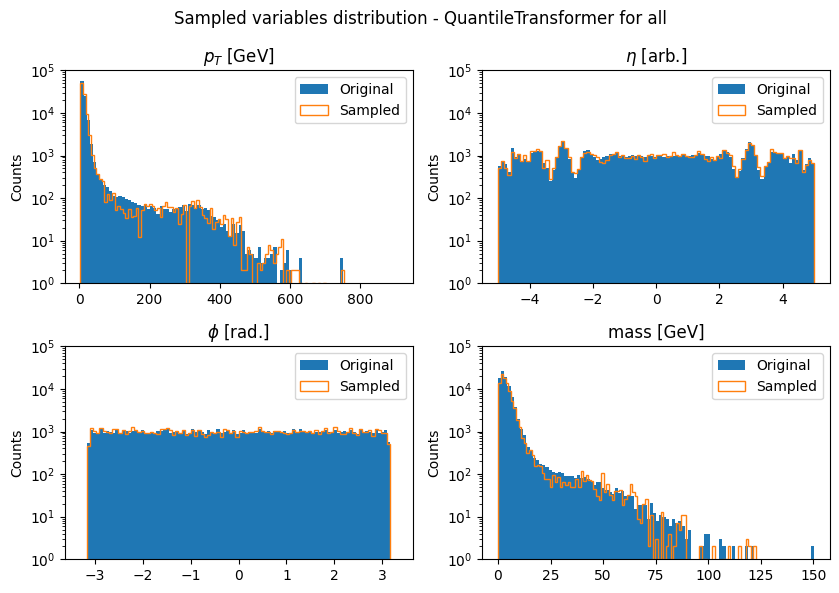

In [14]:
sample = flow.sample(int(len(x)))
sample = sample.cpu().detach().numpy()
sample = x_preprocessor.backward(sample)
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution - QuantileTransformer for all")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample_allquantile.pdf',dpi=190)

In [15]:
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed, gaus, unif = x_compressor.compress(xt)
x_decompressed, gaus_post = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio with QuantileTransformer for all =',size_input/size_compressed)

Size of input file = 5.159041404724121 MB
Size of output file = 3.6342334747314453 MB
Size of compressed file = 1.7468891143798828 MB
Compression ratio with no QuantileTransformer = 2.9532735433842903
